# Executing multiple parameters notebooks with papermill
___


In [25]:
# Necessary imports

import papermill as pm
import s3fs
import numpy as np
from datetime import datetime
import shutil
import os
from tqdm import tqdm

In [2]:
#Connecting to the bucket
s3 = s3fs.S3FileSystem(
    anon=False,
    client_kwargs={
        "endpoint_url": "https://s3.gra.perf.cloud.ovh.net",
    },
)

In [4]:
# Setting up path for the s3 file access
tags_repo = "gfts-ifremer/tags/bargip/cleaned/"
tag_list = [tag.replace(tags_repo,"") for tag in s3.ls(tags_repo)]

cloud_root = "s3://gfts-ifremer/tags/bargip"

In [6]:
# Setting up parameters for the computation
remote = False

if remote == True:
    storage_options = {
        'anon': False, 
        # 'profile' : "gfts",
        'client_kwargs': {
            "endpoint_url": "https://s3.gra.perf.cloud.ovh.net",
            "region_name": "gra",
        }
    }
    scratch_root = f"{cloud_root}/tracks_2"

else: 
    storage_options =None
    scratch_root = "/home/jovyan/notebooks/papermill/tracks_results"


param={
    "storage_options":storage_options,
    "scratch_root":scratch_root
}

In [7]:
# Verifying the params for the location
param

{'storage_options': None,
 'scratch_root': '/home/jovyan/notebooks/papermill/tracks_results'}

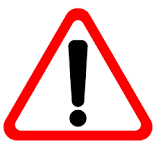

### BE CARFUL FOR THE PATH CHOOSEN FOR **SCRATCH ROOT**, THIS PATH IS THE DIRECTORY WHERE THE RESULT OF THE COMPUTATION WILL BE STORED. WATCH OUT TO NOT OVERWRITE SOMETHING !

___
### Explantion of the code below 
- nbs is a list of the notebooks that has been processed, wether they failed or not.
- The code loops over the tag id present in tag list and calculates the time difference in the tagging events.
- If the fish has observation over 2 days and has not been processed yet, it starts running a parametrized notebook.
- If it succeds, the generated notebook is placed papermill_output/done, else, it goes at papermill_output/failed

In [9]:
import pandas as pd

In [12]:
s3.ls("gfts-ifremer/tags/bargip/")

['gfts-ifremer/tags/bargip/bar_flag_warm_plume.txt',
 'gfts-ifremer/tags/bargip/cleaned',
 'gfts-ifremer/tags/bargip/nuclear_plant_loc.csv',
 'gfts-ifremer/tags/bargip/tracks']

In [18]:
warm_plume = pd.read_csv("s3://gfts-ifremer/tags/bargip/bar_flag_warm_plume.txt",sep = "\t")

In [22]:
tag_list = list(warm_plume[warm_plume["warm_plume"]==True]["tag_name"])

In [23]:
tag_list

['DK_A10502',
 'DK_A10507',
 'DK_A10516',
 'DK_A10521',
 'DK_A10526',
 'DK_A10531',
 'DK_A10543',
 'DK_A10572',
 'DK_A10574',
 'DK_A10580',
 'DK_A10600',
 'DK_A10602',
 'DK_A10611',
 'DK_A10620',
 'DK_A10625',
 'DK_A10632',
 'DK_A10647',
 'DK_A10650']

In [ ]:
%%time
nbs = [nb.replace(".ipynb","") for nb in os.listdir("papermill_output/done")]
for fail in os.listdir("papermill_output/failed/"):
    nbs.append(fail.replace(".ipynb",""))
    
for tag_name in tqdm(tag_list, desc="Processing tags"):
    try :
        te = pd.read_csv(s3.open(f"{cloud_root}/cleaned/{tag_name}/tagging_events.csv"))
        np_datetime1 = np.datetime64(datetime.strptime(te["time"][0], '%Y-%m-%dT%H:%M:%SZ'))
        np_datetime2 = np.datetime64(datetime.strptime(te["time"][1], '%Y-%m-%dT%H:%M:%SZ'))
        time_difference = (np_datetime2 - np_datetime1) / np.timedelta64(1, 'D')
        
        # if (tag_name not in nbs) and time_difference > 2:
        if time_difference > 2:
            
            print(tag_name)
            param["tag_name"] = tag_name
            output_path = f"papermill_output/{tag_name}.ipynb"
            destination_path = f"papermill_output/done/{tag_name}.ipynb"
            pm.execute_notebook(input_path="pangeo-fish_PP.ipynb",output_path=output_path,parameters=param)
            shutil.move(output_path, destination_path)
    except Exception as e:
        print(f"Error for {tag_name}")
        destination_path = f"papermill_output/failed/{tag_name}.ipynb"
        shutil.move(output_path, destination_path)

Processing tags:   0%|          | 0/18 [00:00<?, ?it/s]

DK_A10502


Executing:   0%|          | 0/82 [00:00<?, ?cell/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
